In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Try to use tqdm.notebook, but fall back to regular tqdm if not available

from tqdm import tqdm
import torch
from torchvision import transforms, models
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from pathlib import Path
import cv2


In [291]:
# Set matplotlib parameters for better visualization
plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("ggplot")

DATA_DIR = "../yolo-testing/datasets/waymo-noConf/images/val"

In [23]:
def extract_features_simple(img_path, size=(128, 128)):
    """Extract features by resizing and flattening the image."""
    try:
        # Use OpenCV for faster processing
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, size)
        # Flatten to 1D array
        features = img.flatten() / 255.0  # Normalize to [0, 1]
        return features
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None


In [24]:
def calculate_similarities(img_files, feature_extraction_fn, *args):
    """
    Calculate cosine similarity between consecutive image pairs.

    Args:
        img_files: List of image file paths
        feature_extraction_fn: Function to extract features from images
        *args: Additional arguments to pass to feature_extraction_fn

    Returns:
        DataFrame with image pairs and their similarity scores
    """
    similarities = []
    features_cache = {}  # Cache features to avoid recomputing

    for i in tqdm(range(len(img_files) - 1), desc="Calculating similarities"):
        img1_path = img_files[i]
        img2_path = img_files[i + 1]

        # Extract features for first image (or get from cache)
        if img1_path in features_cache:
            features1 = features_cache[img1_path]
        else:
            features1 = feature_extraction_fn(img1_path, *args)
            features_cache[img1_path] = features1

        # Extract features for second image
        if img2_path in features_cache:
            features2 = features_cache[img2_path]
        else:
            features2 = feature_extraction_fn(img2_path, *args)
            features_cache[img2_path] = features2

        # Skip if either feature extraction failed
        if features1 is None or features2 is None:
            similarities.append(
                {"img1": os.path.basename(img1_path), "img2": os.path.basename(img2_path), "similarity": np.nan}
            )
            continue

        # Calculate cosine similarity
        similarity = cosine_similarity([features1], [features2])[0][0]

        similarities.append(
            {"img1": os.path.basename(img1_path), "img2": os.path.basename(img2_path), "similarity": similarity}
        )

        # Free up some memory by removing oldest cache entry if cache gets too large
        if len(features_cache) > 100:  # Adjust based on your available memory
            oldest_key = list(features_cache.keys())[0]
            del features_cache[oldest_key]

    return pd.DataFrame(similarities)


In [25]:
# Get sorted list of image files in the directory
def get_sorted_image_files(data_dir):
    """Get sorted list of image files in the directory."""
    # Find all image files (supporting common formats)
    image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

    img_files = []
    for ext in image_extensions:
        img_files.extend(list(Path(data_dir).glob(f"*{ext}")))
        img_files.extend(list(Path(data_dir).glob(f"*{ext.upper()}")))

    # Convert to strings and sort
    img_files = [str(f) for f in img_files]

    # Natural sort to handle numerical filenames correctly
    def natural_sort_key(s):
        import re

        return [int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", os.path.basename(s))]

    return sorted(img_files, key=natural_sort_key)


In [292]:
img_files = get_sorted_image_files(DATA_DIR)
print(img_files[:5])

['../yolo-testing/datasets/waymo-noConf/images/val/image_0000.jpeg', '../yolo-testing/datasets/waymo-noConf/images/val/image_0001.jpeg', '../yolo-testing/datasets/waymo-noConf/images/val/image_0002.jpeg', '../yolo-testing/datasets/waymo-noConf/images/val/image_0003.jpeg', '../yolo-testing/datasets/waymo-noConf/images/val/image_0004.jpeg']


In [293]:
similarity_df = calculate_similarities(
  img_files, extract_features_simple, (128, 128)
)
similarity_df.head()

Calculating similarities: 100%|██████████| 3741/3741 [00:43<00:00, 86.71it/s]


,img1,img2,similarity
0,image_0000.jpeg,image_0001.jpeg,0.934501
1,image_0001.jpeg,image_0002.jpeg,0.932876
2,image_0002.jpeg,image_0003.jpeg,0.930380
3,image_0003.jpeg,image_0004.jpeg,0.936104
4,image_0004.jpeg,image_0005.jpeg,0.932364


stage 2

In [31]:
def analyze_similarities(similarity_df):
    """Analyze the distribution of similarities to help determine a threshold."""

    # Plot the distribution of similarity values
    plt.figure(figsize=(12, 6))
    sns.histplot(similarity_df["similarity"], bins=50, kde=True)
    plt.title("Distribution of Cosine Similarity Between Consecutive Frames")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    # Plot similarity values over time (frame pairs)
    plt.figure(figsize=(15, 6))
    plt.plot(similarity_df.index, similarity_df["similarity"])
    plt.title("Cosine Similarity Between Consecutive Frames")
    plt.xlabel("Frame Pair Index")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)

    # Add a horizontal line at the mean - 2*std as a potential threshold
    mean_sim = similarity_df["similarity"].mean()
    std_sim = similarity_df["similarity"].std()
    threshold = mean_sim - 2 * std_sim
    plt.axhline(y=threshold, color="r", linestyle="--", label=f"Potential Threshold: {threshold:.4f} (mean - 2*std)")

    # Highlight potential video transitions
    potential_transitions = similarity_df[similarity_df["similarity"] < threshold]
    if not potential_transitions.empty:
        plt.scatter(
            potential_transitions.index,
            potential_transitions["similarity"],
            color="red",
            s=50,
            label=f"Potential Transitions ({len(potential_transitions)})",
        )

    plt.legend()
    plt.show()

    # Display statistics
    print("Similarity Statistics:")
    print(f"  Mean: {mean_sim:.4f}")
    print(f"  Std Dev: {std_sim:.4f}")
    print(f"  Min: {similarity_df['similarity'].min():.4f}")
    print(f"  Max: {similarity_df['similarity'].max():.4f}")
    print(f"  Potential threshold (mean - 2*std): {threshold:.4f}")

    # Display first few potential transitions
    if not potential_transitions.empty:
        print("\nFirst 10 potential video transitions:")
        display(potential_transitions.head(10))
    else:
        print("\nNo potential transitions found with the suggested threshold.")

    return threshold, potential_transitions


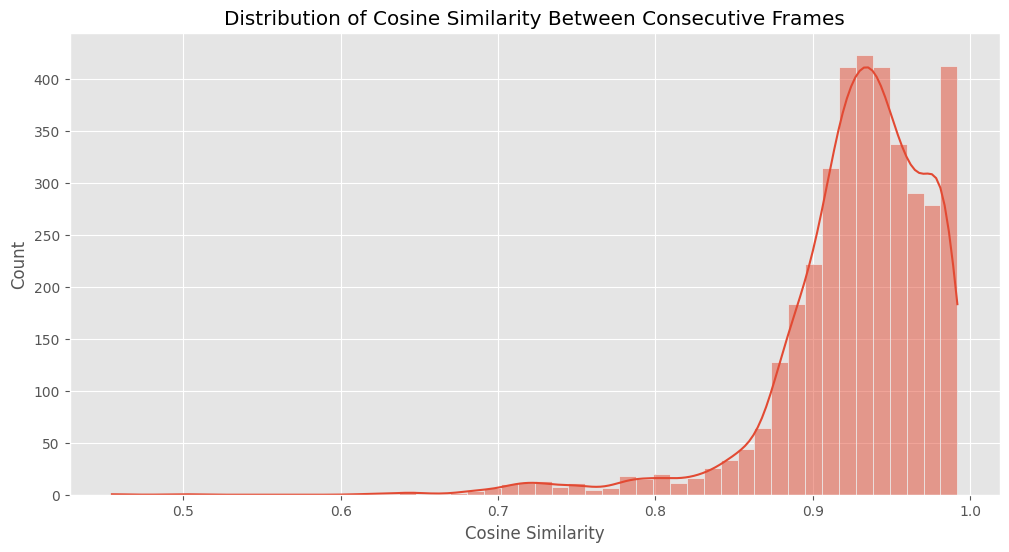

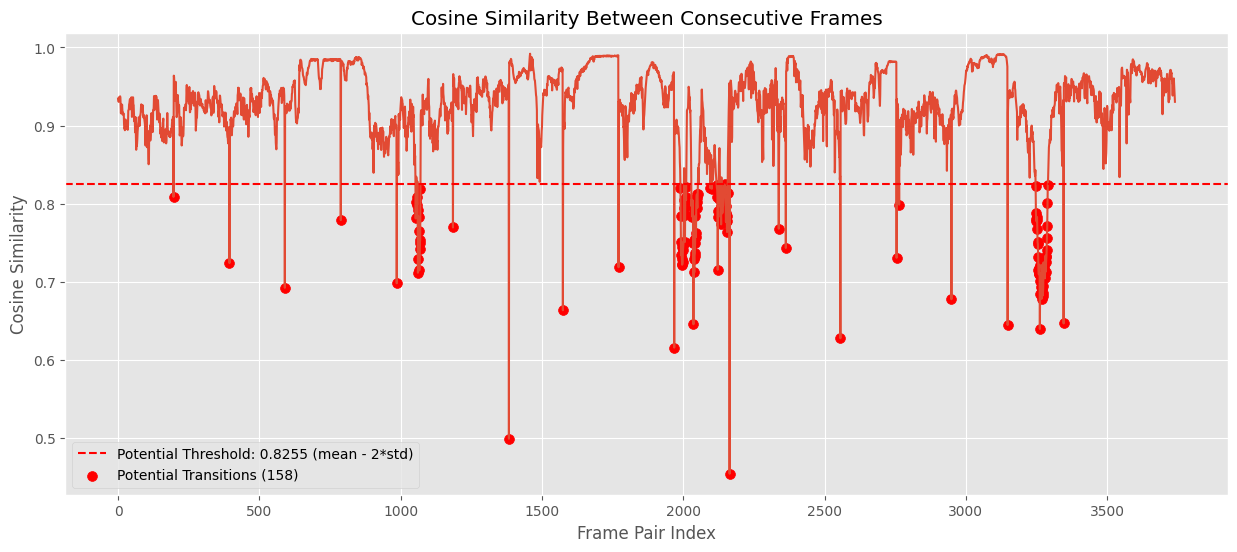

Similarity Statistics:
  Mean: 0.9277
  Std Dev: 0.0511
  Min: 0.4545
  Max: 0.9919
  Potential threshold (mean - 2*std): 0.8255

First 10 potential video transitions:


,img1,img2,similarity
196,image_0196.jpeg,image_0197.jpeg,0.808744
394,image_0394.jpeg,image_0395.jpeg,0.724043
590,image_0590.jpeg,image_0591.jpeg,0.692428
788,image_0788.jpeg,image_0789.jpeg,0.779035
986,image_0986.jpeg,image_0987.jpeg,0.698239
1053,image_1053.jpeg,image_1054.jpeg,0.781157
1054,image_1054.jpeg,image_1055.jpeg,0.802538
1057,image_1057.jpeg,image_1058.jpeg,0.808966
1058,image_1058.jpeg,image_1059.jpeg,0.798645
1060,image_1060.jpeg,image_1061.jpeg,0.791414


In [294]:
threshold, potential_transitions = analyze_similarities(similarity_df)

In [295]:
def identify_transitions(similarity_df, threshold=None):
    """
    Identify video transitions based on similarity threshold.

    Args:
        similarity_df: DataFrame with similarity scores
        threshold: Similarity threshold (if None, automatically calculated as mean - 2*std)

    Returns:
        DataFrame with identified transitions
    """
    if threshold is None:
        # Calculate threshold as mean - 2*std if not provided
        mean_sim = similarity_df["similarity"].mean()
        std_sim = similarity_df["similarity"].std()
        threshold = mean_sim - 2 * std_sim
        print(f"Using automatically calculated threshold: {threshold:.4f}")

    # Find transitions where similarity drops below threshold
    transitions = similarity_df[similarity_df["similarity"] < threshold].copy()

    if transitions.empty:
        print("No transitions found with the current threshold.")
        return transitions

    # Add index information for easier reference
    transitions["pair_index"] = transitions.index

    # Calculate the frame gap between consecutive transitions
    # This can help identify false positives (transitions too close together)
    if len(transitions) > 1:
        transitions["gap_to_next"] = transitions["pair_index"].diff().shift(-1)

    print(f"Found {len(transitions)} potential video transitions")

    return transitions


In [41]:
def remove_transition(transitions_df, row_idx):
    """
    Remove a specific transition from the DataFrame and update gap_to_next for consistency.

    Args:
        transitions_df: DataFrame containing transitions
        row_idx: Index of the transition to remove (integer position in the DataFrame)

    Returns:
        Updated DataFrame with the transition removed
    """
    # Make a copy to avoid modifying the original
    df = transitions_df.copy()

    if row_idx < 0 or row_idx >= len(df):
        print(f"Error: Index {row_idx} is out of bounds for DataFrame with {len(df)} rows")
        return df

    # Get the pair_index of the row to be removed
    removed_pair_idx = df.iloc[row_idx]["pair_index"]

    # If this isn't the last row and there's a previous row, update gap_to_next for the previous row
    if "gap_to_next" in df.columns:
        if row_idx > 0 and row_idx < len(df) - 1:
            # Calculate the new gap for the previous row (which should now point to the next row's pair_index)
            prev_idx = row_idx - 1
            next_idx = row_idx + 1

            next_pair_idx = df.iloc[next_idx]["pair_index"]
            prev_pair_idx = df.iloc[prev_idx]["pair_index"]

            # Update the gap_to_next for the previous row
            df.at[df.index[prev_idx], "gap_to_next"] = next_pair_idx - prev_pair_idx

    # Remove the row
    df = df.drop(df.index[row_idx])

    # Reset index if needed
    df = df.reset_index(drop=True)

    print(f"Removed transition at pair index {removed_pair_idx}")
    print(f"Remaining transitions: {len(df)}")

    return df


In [296]:
transitions = identify_transitions(similarity_df, threshold=0.75)
transitions.reset_index(drop=True, inplace=True)
transitions.head(10)

Found 65 potential video transitions


,img1,img2,similarity,pair_index,gap_to_next
0,image_0394.jpeg,image_0395.jpeg,0.724043,394,196.0
1,image_0590.jpeg,image_0591.jpeg,0.692428,590,396.0
2,image_0986.jpeg,image_0987.jpeg,0.698239,986,75.0
3,image_1061.jpeg,image_1062.jpeg,0.711712,1061,1.0
4,image_1062.jpeg,image_1063.jpeg,0.729129,1062,4.0
5,image_1066.jpeg,image_1067.jpeg,0.714706,1066,1.0
6,image_1067.jpeg,image_1068.jpeg,0.742579,1067,316.0
7,image_1383.jpeg,image_1384.jpeg,0.499327,1383,191.0
8,image_1574.jpeg,image_1575.jpeg,0.663681,1574,197.0
9,image_1771.jpeg,image_1772.jpeg,0.718707,1771,197.0


In [366]:
def insert_transition(transitions_df, insert_position, pair_index, similarity=None):
    """
    Insert a transition at the specified position and update gap_to_next values.

    Args:
        transitions_df: DataFrame containing transitions
        insert_position: Position to insert the new transition (integer index)
        pair_index: The pair_index value for the new transition
        similarity: Similarity value for the new transition (optional)

    Returns:
        Updated DataFrame with the transition inserted
    """
    # Make a copy to avoid modifying the original
    df = transitions_df.copy()

    if insert_position < 0 or insert_position > len(df):
        print(f"Error: Insert position {insert_position} is out of bounds for DataFrame with {len(df)} rows")
        return df

    # Create a new row for the transition
    new_row = {"pair_index": pair_index}

    # set image names
    base_name = str(pair_index)
    # pad base_name with leading zeros to ensure it's 5 characters long
    if len(base_name) < 4:
        base_name = "0" * (4 - len(base_name)) + base_name
    new_row["img1"] = f"image_{base_name}.jpeg"

    base_name = str(pair_index + 1)
    # pad base_name with leading zeros to ensure it's 5 characters long
    if len(base_name) < 4:
        base_name = "0" * (4 - len(base_name)) + base_name
    new_row["img2"] = f"image_{base_name}.jpeg"

    # Set similarity if provided, otherwise use a placeholder value
    if similarity is not None:
        new_row["similarity"] = similarity
    elif "similarity" in df.columns:
        new_row["similarity"] = 0.5  # Placeholder value

    # If we're inserting in the middle (not at the end)
    if insert_position < len(df) and "gap_to_next" in df.columns:
        # Get the next pair_index to calculate the gap for the inserted row
        next_pair_idx = df.iloc[insert_position]["pair_index"]
        new_row["gap_to_next"] = next_pair_idx - pair_index

        # If we're not inserting at the beginning, update the previous row's gap_to_next
        if insert_position > 0:
            prev_idx = insert_position - 1
            prev_pair_idx = df.iloc[prev_idx]["pair_index"]
            df.at[df.index[prev_idx], "gap_to_next"] = pair_index - prev_pair_idx

    # Convert the new row to a DataFrame with one row
    new_row_df = pd.DataFrame([new_row])

    # Insert the new row at the specified position
    if insert_position == 0:
        df = pd.concat([new_row_df, df]).reset_index(drop=True)
    elif insert_position == len(df):
        df = pd.concat([df, new_row_df]).reset_index(drop=True)
    else:
        df = pd.concat([df.iloc[:insert_position], new_row_df, df.iloc[insert_position:]]).reset_index(drop=True)

    # Sort by pair_index to ensure correct order
    df = df.sort_values(by="pair_index").reset_index(drop=True)

    # Recalculate all gaps after insertion for consistency
    if "gap_to_next" in df.columns and len(df) > 1:
        for i in range(len(df) - 1):
            current_pair_idx = df.iloc[i]["pair_index"]
            next_pair_idx = df.iloc[i + 1]["pair_index"]
            df.at[df.index[i], "gap_to_next"] = next_pair_idx - current_pair_idx

    print(f"Inserted transition at pair index {pair_index}")
    print(f"Total transitions: {len(df)}")

    return df


In [374]:
transitions = insert_transition(transitions, 4, 1185)

Inserted transition at pair index 1185
Total transitions: 16


In [251]:
transitions.iloc[18] = {
  "img1": "image_03749.jpeg",
  "img2": "image_03750.jpeg",
  "similarity": 0.5,
  "pair_index": 3749,
  "gap_to_next": 199,
}

In [372]:
transitions = remove_transition(transitions, 4)

Removed transition at pair index 1067
Remaining transitions: 15


In [370]:
transitions.iloc[3] = {
    "img1": "image_0986.jpeg",
    "img2": "image_0987.jpeg",
    "similarity": 0.5,
    "pair_index": 986,
    "gap_to_next": 81,
}
transitions.iloc[3] 

img1           image_0986.jpeg
img2           image_0987.jpeg
similarity                 0.5
pair_index                 986
gap_to_next               81.0
Name: 3, dtype: object

In [384]:
from typing import cast

transitions = cast(pd.DataFrame, transitions)
transitions.to_csv(
  "transitions_val.csv",
  header=["img1", "img2", "similarity", "pair_index", "gap_to_next"],
  index=False,
  
)

In [379]:
transitions

,img1,img2,similarity,pair_index,gap_to_next
0,image_0394.jpeg,image_0395.jpeg,0.724043,394,196.0
1,image_0590.jpeg,image_0591.jpeg,0.692428,590,198.0
2,image_0788.jpeg,image_0789.jpeg,0.500000,788,198.0
3,image_0986.jpeg,image_0987.jpeg,0.500000,986,199.0
4,image_1185.jpeg,image_1186.jpeg,0.500000,1185,198.0
5,image_1383.jpeg,image_1384.jpeg,0.499327,1383,191.0
6,image_1574.jpeg,image_1575.jpeg,0.663681,1574,197.0
7,image_1771.jpeg,image_1772.jpeg,0.718707,1771,197.0
8,image_1968.jpeg,image_1969.jpeg,0.615902,1968,196.0
9,image_2164.jpeg,image_2165.jpeg,0.454541,2164,199.0


In [378]:
gap_mask = transitions["gap_to_next"] > 205
sus_transitions = transitions[gap_mask]
sus_transitions = sus_transitions
print(len(sus_transitions))
print(sus_transitions.head(10))


0
Empty DataFrame
Columns: [img1, img2, similarity, pair_index, gap_to_next]
Index: []


In [380]:
def visualize_specific_transition(transitions_df, img_files, row_idx, context_frames=1):
    """
    Visualize a specific transition with before/after frames for verification.

    Args:
        transitions_df: DataFrame containing transitions
        img_files: List of all image file paths
        row_idx: Index of the transition to visualize (row position in transitions_df)
        context_frames: Number of additional frames to show before/after (default=1)
    """
    if row_idx < 0 or row_idx >= len(transitions_df):
        print(f"Error: Row index {row_idx} is out of bounds for transitions DataFrame with {len(transitions_df)} rows")
        return

    # Extract transition information
    transition = transitions_df.iloc[row_idx]
    pair_idx = int(transition["pair_index"])  # Convert to int to ensure it's a valid index

    # Verify that the pair_idx is valid for the img_files list
    if pair_idx < 0 or pair_idx >= len(img_files) - 1:
        print(f"Error: Pair index {pair_idx} is invalid for image files list with {len(img_files)} items")
        return

    # Get the actual filenames for verification
    file1 = os.path.basename(img_files[pair_idx])
    file2 = os.path.basename(img_files[pair_idx + 1])

    # Calculate the range of frames to display
    start_idx = max(0, pair_idx - context_frames)
    end_idx = min(len(img_files) - 1, pair_idx + 1 + context_frames)

    # Display transition information
    print(f"Transition {row_idx + 1}/{len(transitions_df)}")
    print(f"Pair index: {pair_idx}")
    if "similarity" in transition:
        print(f"Similarity: {transition['similarity']:.4f}")
    if "gap_to_next" in transition:
        print(f"Gap to next transition: {transition['gap_to_next']}")
    print(f"Files: {file1} → {file2}")

    # Create a figure to display the images
    total_frames = end_idx - start_idx + 1
    fig, axes = plt.subplots(1, total_frames, figsize=(4 * total_frames, 4))

    # Handle case where only one frame is shown (axes won't be an array)
    if total_frames == 1:
        axes = [axes]

    # Load and display each frame
    for i, img_idx in enumerate(range(start_idx, end_idx + 1)):
        try:
            # Load the image
            img_path = img_files[img_idx]
            img = plt.imread(img_path)

            # Display the image
            axes[i].imshow(img)

            # Add a title and highlight the transition frames
            if img_idx == pair_idx:
                axes[i].set_title(f"Frame {img_idx}\n(Before)")
                for spine in axes[i].spines.values():
                    spine.set_color("blue")
                    spine.set_linewidth(3)
            elif img_idx == pair_idx + 1:
                axes[i].set_title(f"Frame {img_idx}\n(After)")
                for spine in axes[i].spines.values():
                    spine.set_color("red")
                    spine.set_linewidth(3)
            else:
                axes[i].set_title(f"Frame {img_idx}")

            # Remove axis ticks
            axes[i].set_xticks([])
            axes[i].set_yticks([])

            # Add the filename below the image
            filename = os.path.basename(img_path)
            axes[i].set_xlabel(filename, fontsize=9)

        except Exception as e:
            print(f"Error displaying image at index {img_idx}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image:\n{e}", ha="center", va="center", transform=axes[i].transAxes)

    plt.tight_layout()
    plt.suptitle(f"Transition {row_idx + 1}/{len(transitions_df)} at Pair Index {pair_idx}", y=1.05)
    plt.show()


def review_transitions(transitions_df, img_files, indices=None, context_frames=1):
    """
    Review multiple transitions sequentially.

    Args:
        transitions_df: DataFrame containing transitions
        img_files: List of all image file paths
        indices: List of transition indices to review (default=None, reviews all)
        context_frames: Number of additional frames to show before/after (default=1)
    """
    if indices is None:
        # If no indices provided, review all transitions
        indices = range(len(transitions_df))

    for idx in indices:
        visualize_specific_transition(transitions_df, img_files, idx, context_frames)

        # Ask for user input to continue
        response = input("Press Enter to continue to next transition, or 'q' to quit: ")
        if response.lower() == "q":
            print("Review stopped.")
            break


In [ ]:
review_transitions(transitions, img_files)

In [383]:
transitions.iloc[-1] = {
    "img1": "image_3346.jpeg",
    "img2": "image_3347.jpeg",
    "similarity": 0.646809,
    "pair_index": 3346,
    "gap_to_next": 0,
}
transitions.iloc[-1]

img1           image_3346.jpeg
img2           image_3347.jpeg
similarity            0.646809
pair_index                3346
gap_to_next                0.0
Name: 15, dtype: object

In [388]:
import pandas as pd
import shutil


def rename_dataset_files(dataset_path, mode, transitions_df):
    """
    Rename images and labels in the dataset based on video transitions.

    Args:
        dataset_path: Path to the root of the dataset
        mode: 'train' or 'val'
        transitions_df: DataFrame with video transitions information
    """
    # Input validation
    if mode not in ["train", "val"]:
        raise ValueError("Mode must be either 'train' or 'val'")

    # Setup paths
    images_dir = os.path.join(dataset_path, "images", mode)
    labels_dir = os.path.join(dataset_path, "labels", mode)

    # Check if directories exist
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not os.path.exists(labels_dir):
        raise FileNotFoundError(f"Labels directory not found: {labels_dir}")

    # Get all images and sort them
    all_images = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpeg")])
    print(f"Found {len(all_images)} images in {mode} set")

    # Get all transitions, ensuring they're sorted by pair_index
    transitions = transitions_df.sort_values(by="pair_index").reset_index(drop=True)

    # Calculate number of videos (transitions + 1)
    num_videos = len(transitions) + 1
    vid_digits = len(str(num_videos - 1))  # 0-indexed, so max index is num_videos-1

    # Determine the maximum number of frames in any video to calculate padding
    # Process transitions to get frame counts for each video
    video_starts = [0] + (transitions["pair_index"] + 1).tolist()

    if len(video_starts) > 1:
        # If we have at least one transition, calculate frame counts
        video_lengths = []
        for i in range(len(video_starts) - 1):
            video_lengths.append(video_starts[i + 1] - video_starts[i])
        # Add the last video's length
        video_lengths.append(len(all_images) - video_starts[-1])
    else:
        # If no transitions, all images are in one video
        video_lengths = [len(all_images)]

    # Calculate maximum frames to determine padding
    max_frames = max(video_lengths)
    frame_digits = len(str(max_frames - 1))  # 0-indexed, so max index is max_frames-1

    # Create temporary directory for the rename operation
    temp_dir = os.path.join(dataset_path, f"temp_{mode}")
    temp_images_dir = os.path.join(temp_dir, "images")
    temp_labels_dir = os.path.join(temp_dir, "labels")

    os.makedirs(temp_images_dir, exist_ok=True)
    os.makedirs(temp_labels_dir, exist_ok=True)

    print(f"Renaming files for {num_videos} videos with max {max_frames} frames...")

    # Start renaming files
    current_video = 0  # 0-indexed video counter
    frame_in_video = 0  # 0-indexed frame counter

    # Create a mapping of old to new filenames for later reference
    filename_mapping = {}

    # For each image
    for img_idx, img_name in enumerate(tqdm(all_images)):
        # Check if we've reached a transition point
        if current_video < len(transitions) and img_idx > transitions.iloc[current_video]["pair_index"]:
            current_video += 1
            frame_in_video = 0  # Reset frame counter for new video

        # Get base name without extension
        base_name = os.path.splitext(img_name)[0]

        # Generate new filename
        new_base_name = f"vid_{current_video:0{vid_digits}d}_frame_{frame_in_video:0{frame_digits}d}_{base_name}"
        new_img_name = f"{new_base_name}.jpeg"
        new_label_name = f"{new_base_name}.txt"

        # Store mapping
        filename_mapping[img_name] = new_img_name

        # Copy image with new name to temp directory
        src_img_path = os.path.join(images_dir, img_name)
        dst_img_path = os.path.join(temp_images_dir, new_img_name)
        shutil.copy2(src_img_path, dst_img_path)

        # Check if corresponding label exists and copy it
        label_name = f"{base_name}.txt"
        src_label_path = os.path.join(labels_dir, label_name)
        if os.path.exists(src_label_path):
            dst_label_path = os.path.join(temp_labels_dir, new_label_name)
            shutil.copy2(src_label_path, dst_label_path)
        else:
            print(f"Warning: Label not found for {img_name}")

        # Increment frame counter
        frame_in_video += 1

    # Now replace original directories with renamed files
    # First backup original directories
    backup_images_dir = os.path.join(dataset_path, f"backup_images_{mode}")
    backup_labels_dir = os.path.join(dataset_path, f"backup_labels_{mode}")

    # Move original directories to backup
    shutil.move(images_dir, backup_images_dir)
    shutil.move(labels_dir, backup_labels_dir)

    # Create new empty directories
    os.makedirs(os.path.join(dataset_path, "images", mode), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "labels", mode), exist_ok=True)

    # Move files from temp to new directories
    for filename in os.listdir(temp_images_dir):
        shutil.move(os.path.join(temp_images_dir, filename), os.path.join(dataset_path, "images", mode, filename))

    for filename in os.listdir(temp_labels_dir):
        shutil.move(os.path.join(temp_labels_dir, filename), os.path.join(dataset_path, "labels", mode, filename))

    # Clean up temp directory
    shutil.rmtree(temp_dir)

    print(f"Renamed {len(all_images)} images and their labels in {mode} set")
    print(f"Original files backed up to {backup_images_dir} and {backup_labels_dir}")

    # Save the mapping to a CSV for reference
    mapping_df = pd.DataFrame(list(filename_mapping.items()), columns=["original_filename", "new_filename"])
    mapping_df.to_csv(os.path.join(dataset_path, f"filename_mapping_{mode}.csv"), index=False)
    print(f"Filename mapping saved to {os.path.join(dataset_path, f'filename_mapping_{mode}.csv')}")

    return mapping_df


In [389]:
transitions_train = pd.read_csv("transitions_train.csv", header=0)
transitions_train = cast(pd.DataFrame, transitions_train)
transitions_train.head()


,img1,img2,similarity,pair_index,gap_to_next
0,image_00197.jpeg,image_00198.jpeg,0.711677,197,199.0
1,image_00396.jpeg,image_00397.jpeg,0.535118,396,194.0
2,image_00590.jpeg,image_00591.jpeg,0.566517,590,190.0
3,image_00780.jpeg,image_00781.jpeg,0.591917,780,199.0
4,image_00979.jpeg,image_00980.jpeg,0.597371,979,199.0


In [392]:
dataset_path = "../yolo-testing/datasets/waymo-noConf/"
mode = "train"

In [393]:
mapping_df_train = rename_dataset_files(
    dataset_path, mode, transitions_train
)
mapping_df_train.head()

Found 15617 images in train set
Renaming files for 79 videos with max 199 frames...


 11%|█         | 1673/15617 [00:02<00:20, 690.94it/s]

 25%|██▌       | 3921/15617 [00:06<00:15, 737.22it/s]

 50%|█████     | 7870/15617 [00:12<00:10, 711.43it/s]

 51%|█████▏    | 8013/15617 [00:12<00:10, 693.78it/s]

 52%|█████▏    | 8083/15617 [00:12<00:11, 657.75it/s]

 54%|█████▍    | 8501/15617 [00:13<00:10, 662.56it/s]

 63%|██████▎   | 9794/15617 [00:15<00:11, 494.17it/s]

 65%|██████▌   | 10161/15617 [00:16<00:10, 526.85it/s]

 69%|██████▊   | 10699/15617 [00:18<00:10, 483.94it/s]

 82%|████████▏ | 12767/15617 [00:22<00:05, 537.38it/s]

 86%|████████▌ | 13425/15617 [00:24<00:04, 492.61it/s]

 88%|████████▊ | 13795/15617 [00:24<00:03, 534.23it/s]

 89%|████████▉ | 13954/15617 [00:25<00:03, 508.13it/s]

 97%|█████████▋| 15170/15617 [00:28<00:00, 460.32it/s]

100%|██████████| 15617/15617 [00:29<00:00, 535.26it/s]


Renamed 15617 images and their labels in train set
Original files backed up to ../yolo-testing/datasets/waymo-noConf/backup_images_train and ../yolo-testing/datasets/waymo-noConf/backup_labels_train
Filename mapping saved to ../yolo-testing/datasets/waymo-noConf/filename_mapping_train.csv


,original_filename,new_filename
0,image_00000.jpeg,vid_00_frame_000_image_00000.jpeg
1,image_00001.jpeg,vid_00_frame_001_image_00001.jpeg
2,image_00002.jpeg,vid_00_frame_002_image_00002.jpeg
3,image_00003.jpeg,vid_00_frame_003_image_00003.jpeg
4,image_00004.jpeg,vid_00_frame_004_image_00004.jpeg


In [400]:
transitions_val = pd.read_csv("transitions_val.csv", header=0)
transitions_val = cast(pd.DataFrame, transitions_val)
transitions_val.head()


,img1,img2,similarity,pair_index,gap_to_next
0,196,image_0196.jpeg,image_0197.jpeg,0.500000,198.0
1,394,image_0394.jpeg,image_0395.jpeg,0.724043,196.0
2,590,image_0590.jpeg,image_0591.jpeg,0.692428,198.0
3,788,image_0788.jpeg,image_0789.jpeg,0.500000,198.0
4,986,image_0986.jpeg,image_0987.jpeg,0.500000,199.0


In [401]:
mode = "val"
mapping_df_val = rename_dataset_files(
    dataset_path, mode, transitions_val
)
mapping_df_val.head()

Found 3742 images in val set
Renaming files for 18 videos with max 3740.256629825077 frames...


  8%|▊         | 312/3742 [00:00<00:05, 619.45it/s]

 89%|████████▉ | 3340/3742 [00:04<00:00, 706.60it/s]

100%|██████████| 3742/3742 [00:05<00:00, 700.02it/s]


Renamed 3742 images and their labels in val set
Original files backed up to ../yolo-testing/datasets/waymo-noConf/backup_images_val and ../yolo-testing/datasets/waymo-noConf/backup_labels_val
Filename mapping saved to ../yolo-testing/datasets/waymo-noConf/filename_mapping_val.csv


,original_filename,new_filename
0,image_0000.jpeg,vid_00_frame_00000000000000000_image_0000.jpeg
1,image_0001.jpeg,vid_01_frame_00000000000000000_image_0001.jpeg
2,image_0002.jpeg,vid_02_frame_00000000000000000_image_0002.jpeg
3,image_0003.jpeg,vid_03_frame_00000000000000000_image_0003.jpeg
4,image_0004.jpeg,vid_04_frame_00000000000000000_image_0004.jpeg


In [402]:
def remove_distance_from_labels(dir_path):
    """
    Remove the distance value from all label files in a directory.

    Args:
        dir_path: Path to the directory containing label files (.txt)
    """
    # Check if directory exists
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"Directory not found: {dir_path}")

    # Get all label files in the directory
    label_files = [f for f in os.listdir(dir_path) if f.endswith(".txt")]
    print(f"Found {len(label_files)} label files in {dir_path}")

    # Process each file
    modified_count = 0

    for filename in tqdm(label_files, desc="Processing labels"):
        file_path = os.path.join(dir_path, filename)

        # Read the content of the file
        with open(file_path, "r") as f:
            lines = f.readlines()

        # Process each line by removing the distance value
        modified_lines = []
        for line in lines:
            # Split the line into its components
            parts = line.strip().split()

            # Check if the line has the expected format (at least 6 parts)
            if len(parts) >= 6:
                # Keep only the first 5 parts (class, x_c, y_c, h, w)
                modified_line = " ".join(parts[:5])
                modified_lines.append(modified_line)
            else:
                # If line doesn't have the expected format, keep it as is
                modified_lines.append(line.strip())
                print(f"Warning: Line in {filename} doesn't have expected format: {line.strip()}")

        # Write the modified content back to the file
        with open(file_path, "w") as f:
            f.write("\n".join(modified_lines))

        modified_count += 1

    print(f"Successfully modified {modified_count} label files")


# Example usage:
# remove_distance_from_labels('/path/to/labels/directory')


In [403]:
dataset_path = "../yolo-testing/datasets/waymo-noConf-noDist-vid/"
labels_train = os.path.join(dataset_path, "labels", "train")
labels_val = os.path.join(dataset_path, "labels", "val")
print(labels_train)
print(labels_val)

../yolo-testing/datasets/waymo-noConf-noDist-vid/labels/train
../yolo-testing/datasets/waymo-noConf-noDist-vid/labels/val


In [404]:
remove_distance_from_labels(labels_val)

Found 3725 label files in ../yolo-testing/datasets/waymo-noConf-noDist-vid/labels/val


Processing labels: 100%|██████████| 3725/3725 [00:00<00:00, 5099.85it/s]

Successfully modified 3725 label files


In [405]:
remove_distance_from_labels(labels_train)


Found 15269 label files in ../yolo-testing/datasets/waymo-noConf-noDist-vid/labels/train


Processing labels: 100%|██████████| 15269/15269 [00:04<00:00, 3663.40it/s]

Successfully modified 15269 label files
